In [1]:
#basic
import pandas as pd
import numpy as np

#plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data 
from pandas_datareader.data import DataReader

# For time stamps
from datetime import datetime

#for evaluation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt 

#for modeling
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from keras import optimizers
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed, Bidirectional, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.sequence import TimeseriesGenerator

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

np.random.seed(123)

## Load data

In [2]:
df = DataReader('LUV', data_source='yahoo', start='2012-01-01', end=datetime.now())

In [3]:
data = df.filter(['Close'])

In [4]:
dataset = data.values

## Data preparation

In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [6]:
training_data_len = int(np.ceil( len(dataset) * .9 ))
train_data = scaled_data[0:int(training_data_len), :]

In [7]:
test_data = scaled_data[training_data_len: , :]

In [8]:
train_data.shape

(2196, 1)

In [9]:
def train_val(data):
    train_size = int(len(data) * 0.8)
    train = data[0:train_size]
    val= data[train_size:len(data)]
    return train, val

In [10]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [11]:
def prepare_training(data, n_steps_in, n_steps_out):
    #data = to_dataset(data)
    train, val = train_val(data)
    x_train, y_train = split_sequences(train, n_steps_in, n_steps_out)
    x_val, y_val = split_sequences(val, n_steps_in, n_steps_out)
    features = 1
    return x_train, y_train, x_val, y_val, features

In [12]:
n_steps_in, n_steps_out = 60 , 30
x_train, y_train, x_val, y_val, feature = prepare_training(train_data,n_steps_in, n_steps_out)

In [13]:
x_train.shape

(1667, 60, 1)

In [14]:
y_train.shape

(1667, 30)

## Modeling

In [15]:
# simple Encoder-Decoder model
def creat_model1(n_steps_in, n_steps_out, features):
    model = Sequential()
    model.add(LSTM(128, activation='relu', return_sequences=False, input_shape=(n_steps_in, features)))
    model.add(RepeatVector(n_steps_out))
    model.add(LSTM(128, activation='relu', return_sequences=False))
    model.add(Dense(features))
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

In [16]:
# simple lstm model
def creat_model2(n_steps_in, n_steps_out, features):
    model2 = Sequential()
    model2.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_in, features)))
    model2.add(LSTM(50, activation='relu'))
    model2.add(Dense(n_steps_out))
    model2.add(Activation('linear'))
    
    model2.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_squared_error'])
    
    return model2

In [17]:
#Stop training when a monitored metric has stopped improving.
early = EarlyStopping(monitor='val_loss',patience=5)

#Reduce learning rate when a metric has stopped improving.
reduce = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, mil_lr=0.001)

opt = optimizers.Adam(learning_rate=0.0001)

### Model1

In [18]:
model1 = creat_model1(n_steps_in, n_steps_out, feature)

In [19]:
history1 = model1.fit(x_train, y_train, epochs=50, batch_size=50, verbose=1,
         validation_data=(x_val, y_val), callbacks=[early,reduce])

Epoch 1/50
34/34 [==============================] - 4s 87ms/step - loss: 0.1416 - mean_squared_error: 0.1416 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 2/50
34/34 [==============================] - 2s 73ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 3/50
34/34 [==============================] - 2s 73ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 4/50
34/34 [==============================] - 2s 73ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0083 - val_mean_squared_error: 0.0083
Epoch 5/50
34/34 [==============================] - 3s 76ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 6/50
34/34 [==============================] - 3s 75ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0083 - val_mean_squared_error: 0.0083
Epoch 7/50
34/34 [================

In [20]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________


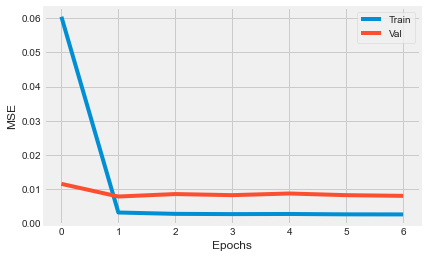

In [21]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(['Train','Val']);

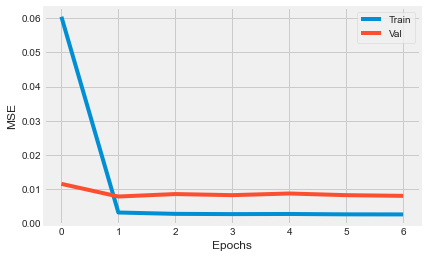

In [22]:
plt.plot(history1.history['mean_squared_error'])
plt.plot(history1.history['val_mean_squared_error'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(['Train','Val']);

### Model2

In [23]:
model2 = creat_model2(n_steps_in, n_steps_out, feature)

In [24]:
history2 = model2.fit(x_train, y_train, epochs=60 , steps_per_epoch=25, verbose=1,
         validation_data=(x_val, y_val))

Epoch 1/60
25/25 [==============================] - 2s 56ms/step - loss: 0.3225 - mean_squared_error: 0.3225 - val_loss: 0.4487 - val_mean_squared_error: 0.4487
Epoch 2/60
25/25 [==============================] - 1s 50ms/step - loss: 0.3205 - mean_squared_error: 0.3205 - val_loss: 0.4323 - val_mean_squared_error: 0.4323
Epoch 3/60
25/25 [==============================] - 1s 51ms/step - loss: 0.2980 - mean_squared_error: 0.2980 - val_loss: 0.4091 - val_mean_squared_error: 0.4091
Epoch 4/60
25/25 [==============================] - 1s 50ms/step - loss: 0.2969 - mean_squared_error: 0.2969 - val_loss: 0.3564 - val_mean_squared_error: 0.3564
Epoch 5/60
25/25 [==============================] - 1s 52ms/step - loss: 0.2270 - mean_squared_error: 0.2270 - val_loss: 0.1803 - val_mean_squared_error: 0.1803
Epoch 6/60
25/25 [==============================] - 1s 50ms/step - loss: 0.1350 - mean_squared_error: 0.1350 - val_loss: 0.1357 - val_mean_squared_error: 0.1357
Epoch 7/60
25/25 [================

In [25]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1530      
_________________________________________________________________
activation (Activation)      (None, 30)                0         
Total params: 32,130
Trainable params: 32,130
Non-trainable params: 0
_________________________________________________________________


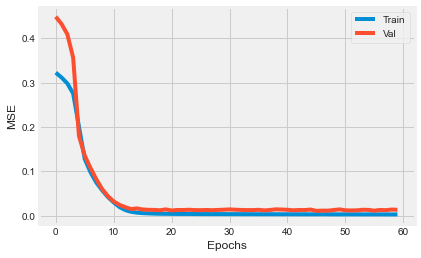

In [26]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(['Train','Val']);

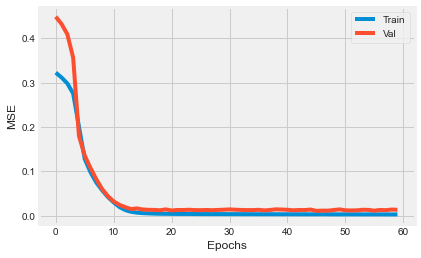

In [27]:
plt.plot(history2.history['mean_squared_error'])
plt.plot(history2.history['val_mean_squared_error'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(['Train','Val']);

## Model1 Evaluation

In [51]:
# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = np.array(history)
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))

    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat


In [52]:
n_input = 60

# history is a list of weekly data
history = [x for x in train_data]
# walk-forward validation over each week
predictions1 = list()
for i in range(len(test_data)):
    # predict the week
    yhat_sequence = forecast(model1, history, n_input)
    # store the predictions
    predictions1.append(yhat_sequence)
    # get real observation and add to history for predicting the next week
    history.append(test_data[i, :])
    
# evaluate predictions days for each week
predictions1 = np.array(predictions1)


In [53]:
rmse1 = np.sqrt(np.mean(((predictions1 -test_data) ** 2)))
print(f'RMSE：{np.round(rmse1, 4)}')

RMSE：0.0284


In [54]:
predictions_inv1 = scaler.inverse_transform(predictions1)

In [55]:
test_inv = scaler.inverse_transform(test_data)

In [56]:
rmse1 = np.sqrt(np.mean(((predictions_inv1 -test_inv) ** 2)))
print(f'RMSE：{np.round(rmse1, 4)}')

RMSE：1.6613


## Model1 Evaluation

In [46]:
n_input = 60

# history is a list of weekly data
history = [x for x in train_data]
# walk-forward validation over each week
predictions2 = list()
for i in range(len(test_data)):
    # predict the week
    yhat_sequence = forecast(model2, history, n_input)
    # store the predictions
    predictions2.append(yhat_sequence)
    # get real observation and add to history for predicting the next week
    history.append(test_data[i, :])
    
# evaluate predictions days for each week
predictions2 = np.array(predictions2)

In [48]:
rmse1 = np.sqrt(np.mean(((predictions2 -test_data) ** 2)))
print(f'RMSE：{np.round(rmse1, 4)}')

RMSE：0.0502


In [49]:
predictions_inv2 = scaler.inverse_transform(predictions2)

In [50]:
rmse1 = np.sqrt(np.mean(((predictions_inv2 -test_inv) ** 2)))
print(f'RMSE：{np.round(rmse1, 4)}')

RMSE：2.9319


## Plot evaluation

In [38]:
#split data
train = data[:training_data_len]
test = data[training_data_len:]

In [57]:
test['Predictions'] =predictions_inv1

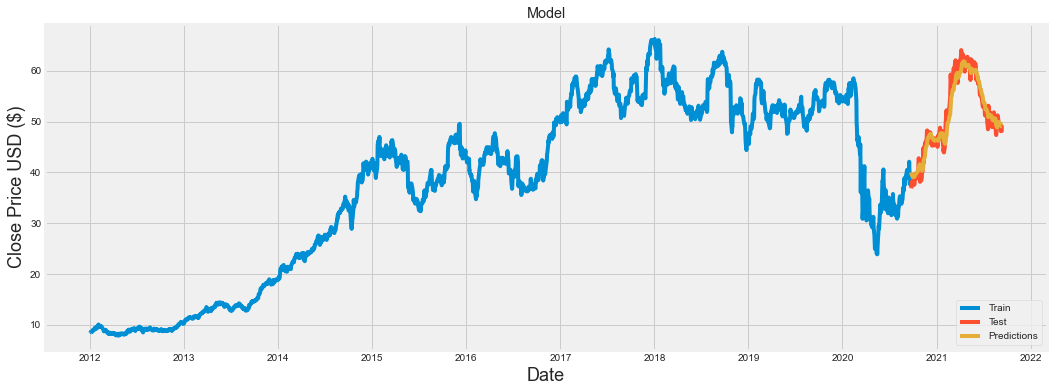

In [58]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(test[['Close','Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

In [41]:
test

,Close,Predictions
Date,,
2020-09-24,36.860001,40.001598
2020-09-25,37.099998,39.609268
2020-09-28,38.240002,39.333157
2020-09-29,37.610001,39.315624
2020-09-30,37.500000,39.197258
...,...,...
2021-09-03,48.860001,49.701546
2021-09-07,48.529999,49.534573
2021-09-08,48.119999,49.333912
